## Overfit-generalization-underfit

In the previous notebook, we presented the general cross-validation framework and how it helps us quantify the training and testing errors as well as their fluctuations.

In this notebook, we put these two errors into perspective and show how they can help us know if our model generalizes, overfits, or underfits.

Let's first load the data and create the same model as in the previous notebook.


In [16]:
import sklearn
print(sklearn.__version__)

1.2.2


In [17]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 24.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.datasets import fetch_california_housing
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ValidationCurveDisplay

In [2]:
housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target
target *= 100  # rescale the target in k$



Note

If you want a deeper overview regarding this dataset, you can refer to the Appendix - Datasets description section at the end of this MOOC.


In [3]:
regressor = DecisionTreeRegressor()

## Overfitting vs. underfitting

To better understand the generalization performance of our model and maybe find insights on how to improve it, we compare the testing error with the training error. Thus, we need to compute the error on the training set, which is possible using the cross_validate function.


In [4]:
cv = ShuffleSplit(n_splits=30, test_size=0.2, random_state=0)
cv_results = cross_validate(
    regressor,
    data,
    target,
    cv=cv,
    scoring="neg_mean_absolute_error",
    return_train_score=True,
    n_jobs=2,
)
cv_results = pd.DataFrame(cv_results)

The cross-validation used the negative mean absolute error. We transform the negative mean absolute error into a positive mean absolute error.

In [5]:
scores = pd.DataFrame()
scores[["train error", "test error"]] = -cv_results[
    ["train_score", "test_score"]
]

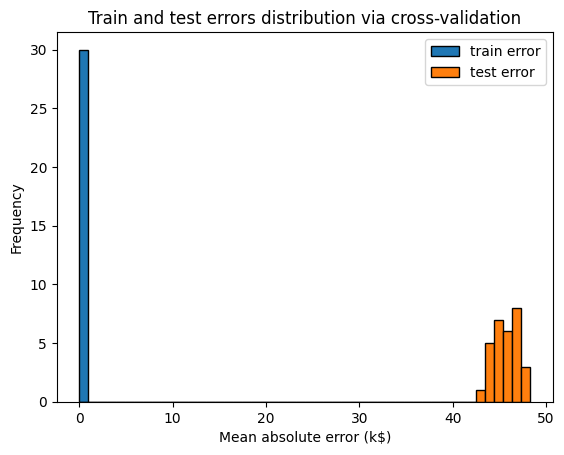

In [6]:
scores.plot.hist(bins=50, edgecolor="black")
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Train and test errors distribution via cross-validation")

By plotting the distribution of the training and testing errors, we get information about whether our model is over-fitting, under-fitting (or both at the same time).

Here, we observe a small training error (actually zero), meaning that the model is not under-fitting: it is flexible enough to capture any variations present in the training set.

However the significantly larger testing error tells us that the model is over-fitting: the model has memorized many variations of the training set that could be considered "noisy" because they do not generalize to help us make good prediction on the test set.
## Validation curve

We call hyperparameters those parameters that potentially impact the result of the learning and subsequent predictions of a predictor. For example:

    the number of neighbors in a k-nearest neighbor model;

    the degree of the polynomial.

Some model hyperparameters are usually the key to go from a model that underfits to a model that overfits, hopefully going through a region were we can get a good balance between the two. We can acquire knowledge by plotting a curve called the validation curve. This curve can also be applied to the above experiment and varies the value of a hyperparameter.

For the decision tree, the max_depth hyperparameter is used to control the tradeoff between under-fitting and over-fitting.


CPU times: user 609 ms, sys: 79.3 ms, total: 688 ms
Wall time: 28.5 s


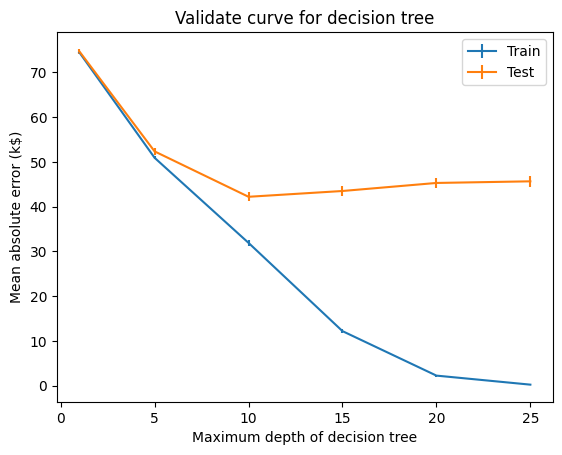

In [7]:
%%time


max_depth = np.array([1, 5, 10, 15, 20, 25])
disp = ValidationCurveDisplay.from_estimator(
    regressor,
    data,
    target,
    param_name="max_depth",
    param_range=max_depth,
    cv=cv,
    scoring="neg_mean_absolute_error",
    negate_score=True,
    std_display_style="errorbar",
    n_jobs=2,
)
_ = disp.ax_.set(
    xlabel="Maximum depth of decision tree",
    ylabel="Mean absolute error (k$)",
    title="Validate curve for decision tree",
)

The validation curve can be divided into three areas:

    For max_depth < 10, the decision tree underfits. The training error and therefore the testing error are both high. The model is too constrained and cannot capture much of the variability of the target variable.

    The region around max_depth = 10 corresponds to the parameter for which the decision tree generalizes the best. It is flexible enough to capture a fraction of the variability of the target that generalizes, while not memorizing all of the noise in the target.

    For max_depth > 10, the decision tree overfits. The training error becomes very small, while the testing error increases. In this region, the models create decisions specifically for noisy samples harming its ability to generalize to test data.

Note that for max_depth = 10, the model overfits a bit as there is a gap between the training error and the testing error. It can also potentially underfit also a bit at the same time, because the training error is still far from zero (more than 30 k$), meaning that the model might still be too constrained to model interesting parts of the data. However, the testing error is minimal, and this is what really matters. This is the best compromise we could reach by just tuning this parameter.

Be aware that looking at the mean errors is quite limiting. We should also look at the standard deviation to assess the dispersion of the score. For such purpose, we can use the parameter std_display_style to show the standard deviation of the errors as well. In this case, the variance of the errors is small compared to their respective values, and therefore the conclusions above are quite clear. This is not necessarily always the case.
